## Initialization

N is the number of training samples. Various nonlinear systems such as Brockett integrator, unicycle, a fully-actuated system are commented. Change the system dimension $n$ to appropriately use any of these systems. Variables $mu$ and $sigma$ are use to control the mean and covariance of the target gaussian distribution.

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import torch.nn.functional as F
from scipy.spatial.distance import pdist, squareform
import numpy as np


print('Torch version: ')
print(torch.__version__)

torch.pi = torch.acos(torch.zeros(1)).item() * 2


# Nest = 1000
N = 700

n = 5
control_dim = 2 

band = 0.2

dt = torch.tensor(0.05)

t_hor = 5

Tsteps = int(t_hor/dt)

mu = torch.tensor(0)
sigma = torch.tensor(.3)

domain = 3

# ref_points = torch.normal(0,domain,(N,n)) 
rfp_domain = 20
ref_points = torch.rand((N,n))*2*rfp_domain - rfp_domain

# print(ref_points)

def forward_diff(x):
      Nsize = x.size(0)

#       forward_step = x + dt * (-0.5 * 0.5 * x ) + sqrt(0.5) * torch.normal(0, sqrt(dt), (Nsize,n)) #### song's paper, diffuse to standard gaussian

      forward_step = x + torch.normal(0, 1, (Nsize,n)) * torch.sqrt(dt)
    
#       forward_step = x + .2

      forward_step = torch.where(forward_step.clone()>domain, domain, forward_step.clone())

      forward_step = torch.where(forward_step.clone()<-domain, -domain, forward_step.clone())

      return forward_step
    
def custom_kde(x):

    N = x.shape[0]

    mu = x.mean(dim=0)
    xstar = x + torch.normal(0,0.051,x.shape)
    sigma = torch.diag(torch.std(xstar.clone(),dim=0))
    logprobs = torch.zeros(N,1)

    for i in range(N):
        logprobs = logprobs + torch.reshape(torch.distributions.MultivariateNormal(x[i,:],sigma).log_prob(x),(N,1))

    return logprobs/N

# def kde_fast(x):
#     s = 0.2
    
    
#     ### torch method ###
#     xcl = x.clone()

#     p_mat = torch.cdist(xcl,ref_points,p=2)

#     K = 1/(s * torch.sqrt(2 * torch.tensor(torch.pi))) * torch.exp(-torch.square(p_mat)/s) + 1e-6

#     Kmean = K.mean(dim=0)
#     Klog = torch.log(Kmean)

#     return Klog

def kld_direct(xsamp,ysamp):
    
    s = 1e-1
    
    p_mat_xx = torch.cdist(xsamp,xsamp,p=2)
    
    p_mat_xy = torch.cdist(xsamp,ysamp,p=2)
    
#     print(p_mat_xx)
    
    K_x = 1/(s*torch.sqrt(2 * torch.tensor(torch.pi))) * torch.exp(-torch.square(p_mat_xx/s)) + 1e-8
    
#     print(K_x)

    K_y = 1/(s*torch.sqrt(2 * torch.tensor(torch.pi))) * torch.exp(-torch.square(p_mat_xy/s)) + 1e-8

    K_xsum = K_x.sum(dim=1)
    
    K_ysum = K_y.sum(dim=1)
    
    logxy = 1/N*torch.log(torch.div(K_xsum,K_ysum))
    
    kld = logxy.sum()

    return kld

def l2_prob(xsamp,ysamp):
    
    s = 0.1
    
    p_mat_xx = torch.cdist(xsamp,xsamp,p=2)
    
    p_mat_xy = torch.cdist(xsamp,ysamp,p=2)
    
    
    K_x = 1/(s**n * torch.sqrt(2 * torch.tensor(torch.pi))) * torch.exp(-torch.square(p_mat_xx/s)) + 1e-8

    K_y = 1/(s**n * torch.sqrt(2 * torch.tensor(torch.pi))) * torch.exp(-torch.square(p_mat_xy/s)) + 1e-8    
    
    dist = 1/N**2 * K_x.sum() - 2/N**2 * K_y.sum()
    
    return dist
    
    
# def JSD(P,Q): ###Jensen Shannon Divergence ###
#     pexp = torch.exp(P)
#     qexp = torch.exp(Q)
#     Mexp = 0.5*(pexp + qexp)
    
#     M = torch.log(Mexp)
    
#     T1 = F.kl_div(P,M,reduction='sum',log_target=True) * 1e2
#     T2 = F.kl_div(Q,M,reduction='sum',log_target=True) * 1e2
    
#     jsd = 0.5 * (T1+T2)
    
#     return jsd


def f(x):
    return 0

# def g(x,u): 
#     return u

# def g(x,u):  ## fully actuated
    
#     ndat = x.shape[0]
#     dx1 = torch.reshape(-x[:,0].clone() * u[:,0].clone(),(ndat,1))
#     dx2 = torch.reshape(x[:,1].clone() * u[:,1].clone(),(ndat,1))
#     dx3 = torch.reshape(-x[:,2].clone() * u[:,2].clone(),(ndat,1))

#     return torch.hstack((dx1,dx2,dx3))


# def g(x,u):   ### Brockett integrator

#     ndat = x.shape[0]
#     dx1 = torch.reshape(u[:,0].clone(),(ndat,1))
#     dx2 = torch.reshape(u[:,1].clone(),(ndat,1))
#     dx3 = torch.reshape(x[:,0].clone()*u[:,1].clone()- x[:,1].clone()* u[:,0].clone(),(ndat,1))  

#     return torch.hstack((dx1,dx2,dx3))




# def g(x,u):   ### unicycle dynamics

#     ndat = x.shape[0]
#     dx1 = torch.reshape(torch.cos(x[:,2].clone()) * u[:,0].clone(),(ndat,1))
#     dx2 = torch.reshape(torch.sin(x[:,2].clone()) * u[:,0].clone(),(ndat,1))
#     dx3 = torch.reshape(u[:,1].clone(),(ndat,1))

#     return torch.hstack((dx1,dx2,dx3))

def g(x,u):   ### 5 dimenstional system dynamics

    ndat = x.shape[0]
    dx1 = torch.reshape(u[:,0].clone(),(ndat,1))
    dx2 = torch.reshape(u[:,1].clone(),(ndat,1))
    dx3 = torch.reshape(torch.cos(x[:,1].clone()) * u[:,0].clone(),(ndat,1))
    dx4 = torch.reshape(torch.cos(x[:,2].clone()) * u[:,0].clone(),(ndat,1))
    dx5 = torch.reshape(torch.cos(x[:,3].clone()) * u[:,0].clone(),(ndat,1))

    return torch.hstack((dx1,dx2,dx3,dx4,dx5))


def reverse(x,u):
    xsize = x.size(0)
    fx = f(x)
    gxu = g(x,u)

    xplus = x +  dt * (fx + gxu) #+ torch.normal(0,0.00051,(xsize,n))

    xplus = torch.where(xplus.clone()>domain,domain,xplus.clone())

    xplus = torch.where(xplus.clone()< -domain,-domain,xplus.clone())

    return xplus


def cost_fn(fwd_traj,rev_traj,indices):  ### cost fn depends only on means and covariances ###
    cost = 0
    
    fwd_samp_traj = fwd_traj[:,:,indices].clone()
    
    rev_samp_traj = rev_traj[:,:,indices].clone()
    
    ######### Mean Computation ##########
    fwd_means = torch.mean(fwd_samp_traj[:,0:n,:],dim=0)
   
    fwd_means = torch.flip(fwd_means,dims = [1])
      
    rev_means = torch.mean(rev_samp_traj[:,0:n,:],dim=0)
    
    diff_means = fwd_means - rev_means
    
    mean_cost = torch.norm(diff_means,dim = 0)
    
#     mean_cost[-1] = 5 * mean_cost[-1].clone()
    
#     mean_cost = mean_cost.sum()
    
    fin_mean = mean_cost.clone()
    
    fin_mean[-1] = mean_cost[-1].clone() * 5
    
    fin_mean = fin_mean.sum()
    
    
    ######### Std Dev Computation #########
    
    fwd_stds = torch.zeros((n,indices.shape[0]))
    rev_stds = torch.zeros((n,indices.shape[0]))
    
    
    for i in range(indices.shape[0]):
        fwd_stds[:,i] = fwd_samp_traj[:,0:n,i].clone().std(dim=0)
        rev_stds[:,i] = rev_samp_traj[:,0:n,i].clone().std(dim=0)

   
    fwd_stds = torch.flip(fwd_stds,dims = [1])
    
    diff_stds = fwd_stds - rev_stds
    
    std_cost = torch.norm(diff_stds,dim = 0)
    
#     print(std_cost)
    
#     std_cost[-1] = 5 * std_cost[-1].clone()
    
#     std_cost = std_cost.sum()
    
    fin_std = std_cost.clone()
    
    fin_std[-1] = std_cost[-1].clone() * 5
    
    fin_std[-2] = std_cost[-2].clone() * 3
    
    fin_std = fin_std.sum()
    
    ######## Final cost ########
        
    cost = 1 * fin_mean + 5 * fin_std
    
    return cost


def cost_fn_kld(fwd_traj,rev_traj,indices):  ### cost fn based on KL divergence ###
    cost = 0
    
    fwd_flip_traj = torch.flip(fwd_traj.clone(),dims = [2])
    
    fwd_samp_flip = fwd_flip_traj[:,:,indices].clone()
    
    rev_samp_traj = rev_traj[:,:,indices].clone()
       
    kld_array = torch.zeros(indices.shape)
    
    inter_weights = 0.2    
    
    for i in range(indices.shape[0]):
         kld_array[i] = kld_direct(fwd_samp_flip[:,:,i],rev_samp_traj[:,:,i])

            
    kld_array[1:indices.shape[0]-2] = inter_weights * kld_array[1:indices.shape[0]-2]  

    #     cost = torch.dot(kld_array,kld_array)
#     print(kld_array)
    cost= torch.sum(torch.abs(kld_array))
    
    return cost
    
    
# def cost_l2(fwd_traj,rev_traj,indices):   ### cost fn based on L2 distance between distributions ###
#     cost = 0
    
#     fwd_samp_traj = fwd_traj[:,:,indices].clone()
    
#     rev_samp_traj = rev_traj[:,:,indices].clone()
    
#     fwd_samp_flip = torch.flip(fwd_samp_traj.clone(),dims = [2])
    
#     cost_array = torch.zeros(indices.shape)
    
# #     print(kld_array.shape)
    
    
#     for i in range(indices.shape[0]):
#         fwd_score = kde_fast(fwd_samp_flip[:,:,i])
#         rev_score = kde_fast(rev_samp_traj[:,:,i])
        
#         cost_array[i] = torch.norm(fwd_score - rev_score)**2
        
#     cost_array[1:indices.shape[0]-2] = 0.1 * cost_array[1:indices.shape[0]-2]
    
#     cost = torch.sum(cost_array)
    
#     return cost



Torch version: 
2.0.1


tensor([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
        90, 99])


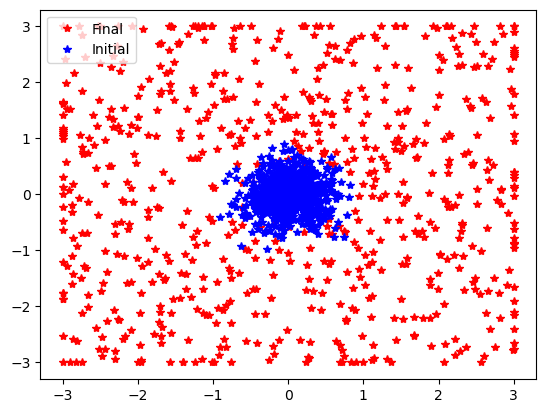

In [4]:
def init_sample(N):

    D = torch.normal(mu,sigma,(N,n))
    return D


D = init_sample(N)



Dtraj = torch.zeros((N,n,Tsteps))

Dtraj[:,:,0] = D

no_samples = 20

samples = torch.arange(0,Tsteps,Tsteps/no_samples)

samples[-1] = torch.tensor(Tsteps - 1)

# samples = torch.cat((samples,torch.tensor(Tsteps/no_samples - 1)))

samples = samples.to(torch.long)

print(samples)

for j in range(1,Tsteps):

    #forward sde f(x) = 0.5, g(x) = sqrt(0.5)
    # Dtraj[:,:,j] = Dtraj[:,:,j-1] + dt * (-0.5 * 0.5 * Dtraj[:,:,j-1] ) + sqrt(0.5) * torch.normal(0, sqrt(dt), (N,n))

    Dtraj[:,:,j] = forward_diff(Dtraj[:,:,j-1])


Dlast = Dtraj[:,:,-1]

plt.figure('forward process')
plt.plot(Dtraj[:,0,-1].detach(),Dtraj[:,1,-1].detach(),'r*')
plt.plot(Dtraj[:,0,0].detach(),Dtraj[:,1,0].detach(),'b*')
plt.legend(['Final','Initial'])



# Pre-training

Once the forward SDE generates a trajectory of distributions, define a NN as the controller for the considered dynamical system:

\begin{align}
f(x) + g(x,u)
\end{align}

Functions $f(x)$ and $g(x,u)$ have been defined in the first cell.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

input_dim = n+1


class NNControl(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 150,bias=True)  # 2 input features, 5 hidden units
        self.fc2 = nn.Linear(150,200,bias=True)
#         self.fc3 = nn.Linear(300,200,bias=True)
        self.fc3 = nn.Linear(200,20,bias=True)
        self.relu = nn.ReLU()

        self.out = nn.Linear(20, control_dim)  # 5 hidden units, 1 output



    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.relu(x)    
        
#         x = self.fc4(x)
#         x = self.relu(x) 

        x = self.out(x)
        
        

        return x



nncontrol = NNControl()

# optimizer = optim.Adam(nncontrol.parameters())


In [4]:
optimizer = optim.Adam(nncontrol.parameters(),lr=0.005,weight_decay = 1e-6)

n_epochs = 150

for step in range(n_epochs):

    optimizer.zero_grad()

    Dtrajreverse = torch.zeros((N,n,Tsteps))
    Dtrajreverse[:,:,0] = Dlast

    cost = torch.zeros((1,1))
    control = 0

    for j in range(1,Tsteps):

        tvec = j*dt * torch.ones(N,1)

        nninput = torch.cat((Dtrajreverse[:,:,j-1],tvec),1)

        control = nncontrol(nninput)

        Dtrajreverse[:,:,j] = reverse(Dtrajreverse[:,:,j-1],control)

#     cost = cost_fn(Dtraj,Dtrajreverse,samples)
    cost = cost_fn_kld(Dtraj,Dtrajreverse,samples)
#     cost = cost_l2(Dtraj,Dtrajreverse,samples)
       
    print('iter = ' + '{:2d}'.format(step)+', cost = ' + "{:.6f}".format(cost.item()))
    
    torch.autograd.set_detect_anomaly(True)
    cost.backward()

    optimizer.step()   
    
    
    


iter =  0, cost = 191.139221
iter =  1, cost = 172.246368
iter =  2, cost = 157.898270
iter =  3, cost = 161.092194
iter =  4, cost = 153.942245
iter =  5, cost = 158.418671
iter =  6, cost = 149.273270
iter =  7, cost = 153.206223
iter =  8, cost = 150.927444
iter =  9, cost = 144.469940
iter = 10, cost = 146.587311
iter = 11, cost = 145.160126
iter = 12, cost = 140.591873
iter = 13, cost = 140.040710
iter = 14, cost = 139.402328
iter = 15, cost = 136.022873
iter = 16, cost = 133.835083
iter = 17, cost = 132.536118
iter = 18, cost = 128.869781
iter = 19, cost = 126.371506
iter = 20, cost = 123.497658
iter = 21, cost = 120.218948
iter = 22, cost = 119.562225
iter = 23, cost = 113.496902
iter = 24, cost = 110.202820
iter = 25, cost = 109.556381
iter = 26, cost = 106.704163
iter = 27, cost = 105.515320
iter = 28, cost = 99.329849
iter = 29, cost = 98.622803
iter = 30, cost = 96.230850
iter = 31, cost = 92.268234
iter = 32, cost = 92.396767
iter = 33, cost = 86.357445
iter = 34, cost = 88

# Post-Training
Once the NN is trained, it can be used as a controller that depends on time and space.



tensor([-0.5980, -0.2662], grad_fn=<SubBackward0>)


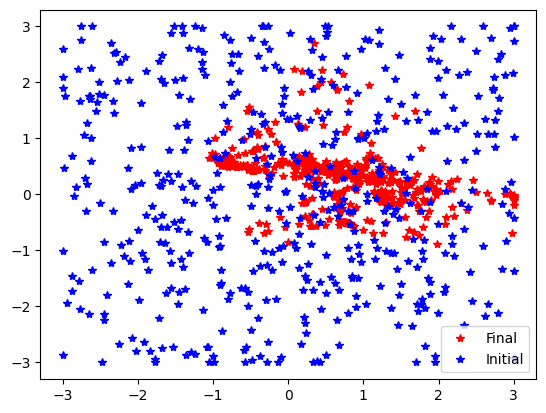

In [5]:
print(Dtraj[:,0:2,0].mean(dim=0) - Dtrajreverse[:,0:2,-1].mean(dim=0))

plt.plot(Dtrajreverse[:,0,-1].detach(),Dtrajreverse[:,1,-1].detach(),'r*')
plt.plot(Dtrajreverse[:,0,0].detach(),Dtrajreverse[:,1,0].detach(),'b*')
plt.legend(['Final','Initial'])

# Testing 

Sample from the probability distribution of initial states.

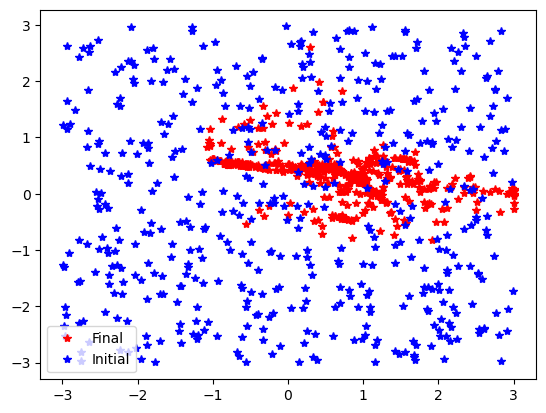

In [6]:
Dtrajreverse = torch.zeros((N,n,Tsteps))

Dtrajreverse[:,:,0] = torch.rand((N,n)) * 2 * domain - domain

# Dtrajreverse[:,:,0] = torch.normal(0,1,(N,n))

controltraj = []

for j in range(1,Tsteps):

      tvec = j*dt * torch.ones(N,1)

      nninput = torch.cat((Dtrajreverse[:,:,j-1],tvec),1)

      control = nncontrol(nninput)

      controltraj.append(control)

      Dtrajreverse[:,:,j] = reverse(Dtrajreverse[:,:,j-1],control)
      
plt.plot(Dtrajreverse[:,0,-1].detach(),Dtrajreverse[:,1,-1].detach(),'r*')
plt.plot(Dtrajreverse[:,0,0].detach(),Dtrajreverse[:,1,0].detach(),'b*')
plt.legend(['Final','Initial'])




# Save files 

The following cell saves the reverse trajectory stored in *dtrajreverse* as a the matlab variable *dtrajreverse.mat*. 

In [7]:

import numpy as np

from scipy.io import savemat

traj = {'traj':Dtrajreverse.detach().numpy()}

savemat('dtrajreverse.mat',traj)

# torch.save(nncontrol.state_dict(), 'nncontrol.pt')
